In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
# tf.keras.backend.set_floatx(
#     'float32'
# )
import numpy as np
import seaborn as sns; 
tfd = tf.contrib.distributions
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from tqdm import tqdm_notebook as tqdm
from scipy.stats import norm, uniform, cauchy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1.15.0


In [40]:
tol = 1e-35
bs = 500
K = 3
do = 0.8

def ratios_critic(x, prob = 1, reuse=False):
    with tf.variable_scope('critic') as scope:
        if reuse:
            scope.reuse_variables()
        x = tf.expand_dims(x,1)
        
        h1 = slim.fully_connected(x, 100, activation_fn=tf.nn.softplus)
        h1 = tf.nn.dropout(h1,prob)
        h1 = slim.fully_connected(h1, 50, activation_fn=tf.nn.softplus)
        h1 = tf.nn.dropout(h1,prob)
        
        h2 = slim.fully_connected(x, 100, activation_fn=tf.nn.softplus)
        h2 = tf.nn.dropout(h2,prob)
        h2 = slim.fully_connected(h2, 50, activation_fn=tf.nn.softplus)
        h2 = tf.nn.dropout(h2,prob)
        
        log_d = tf.concat([-h1,-h2],1)
        log_d = slim.fully_connected(log_d, 2, activation_fn=None)
        
    return tf.squeeze(log_d)


In [41]:
tf.reset_default_graph()
tf.random.set_random_seed(40)

mu_1 = -1.
mu_2 = 1.
mu_3 = 0.
scale_p=0.2
scale_q=0.1
scale_m=3.

p = tfd.Normal(loc=mu_1, scale=scale_p)
q = tfd.Normal(loc=mu_2, scale=scale_q)
base = tfp.distributions.Cauchy(loc=mu_3, scale=scale_m)


samples = base.sample([bs]) 
p_samples = p.sample([bs]) 
q_samples = q.sample([bs])
m_samples = samples
# m_samples = samples + (p_samples+q_samples)/2.
m_samples2 = m_samples# samples[bs:]

#Ratio by log of prob evaluated at samples from base
log_ratio_p_q = p.log_prob(m_samples) - q.log_prob(m_samples)
#KL from CoB
kld = tf.reduce_mean(log_ratio_p_q) 


In [42]:
# Build 2 Discriminator Networks (one from noise input, one from generated samples)

ratio_on_p = ratios_critic(p_samples, do)
ratio_on_q = ratios_critic(q_samples, do,reuse=True)
ratio_on_m = ratios_critic(m_samples, do,reuse=True)
# disc_m_gen = ratios_critic(m_samples2, do,reuse=True)

logitP = tf.concat([ratio_on_p-tf.expand_dims(base.log_prob(p_samples),1),tf.expand_dims(base.log_prob(p_samples),1)],1)
logitQ = tf.concat([ratio_on_q-tf.expand_dims(base.log_prob(q_samples),1),tf.expand_dims(base.log_prob(q_samples),1)],1)
logitM = tf.concat([ratio_on_m-tf.expand_dims(base.log_prob(m_samples),1),tf.expand_dims(base.log_prob(m_samples),1)],1)

a = np.tile([1,0,0],bs)
b = np.tile([0,1,0],bs)
c = np.tile([0,0,1],bs)

label_a = tf.reshape(a,[bs,K])
label_b = tf.reshape(b,[bs,K])
label_c = tf.reshape(c,[bs,K])


disc_loss_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logitP, labels=label_a))
disc_loss_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logitQ, labels=label_b))
disc_loss_3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logitM, labels=label_c))
# disc_loss_4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m_gen, labels=label_c))

dloss = disc_loss_1 + disc_loss_2 + 1*disc_loss_3 #+ 0.5*disc_loss_4 

# Define CoB DRE

log_r_p_m = ratios_critic(m_samples, reuse=True) 
log_r_p_from_m_direct = log_r_p_m 

t_vars = tf.trainable_variables()
c_vars = [var for var in t_vars if 'critic' in var.name]

optim = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(dloss, var_list=t_vars)

init = tf.global_variables_initializer()
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)


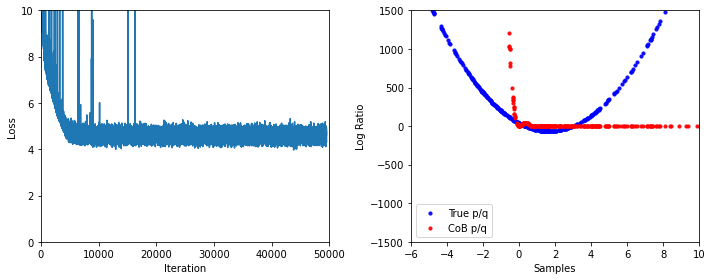

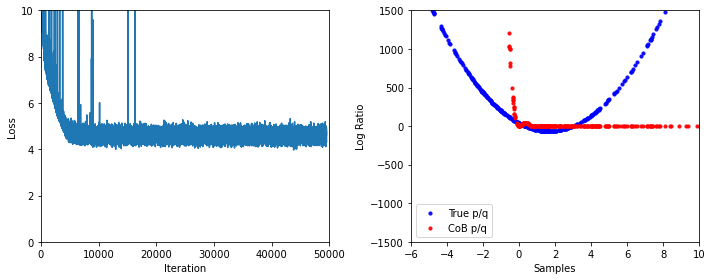

In [43]:
N=50000
loss_store=[]
fig, [ax1,ax2] = plt.subplots(1, 2,figsize=(10,4))

line, = ax1.plot([0,1],[0,1])
x, y = np.random.random((2, 500))
scat1 = ax2.scatter(x,y,label='True p/q',alpha=0.9,s=10.,c='b')
scat2 = ax2.scatter(x,y,label='CoB p/q',alpha=0.9,s=10.,c='r')

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_xlim([0,N])
ax1.set_ylim([0,10])

ax2.set_xlabel("Samples")
ax2.set_ylabel("Log Ratio")
ax2.legend(loc='best')
ax2.set_xlim([-6,10])
ax2.set_ylim([-1500,1500])

plt.tight_layout()

pbar = range(0,N)
for i in pbar:

    feed_dict = {}
    l,_ = sess.run([dloss, optim],feed_dict=feed_dict)
    loss_store.append(l)
    if i%500==0:
        line.set_data(range(len(loss_store)), loss_store)
        xs, lpq, lpqm = sess.run([m_samples, log_ratio_p_q, log_r_p_m],feed_dict={})
        scat1.set_offsets(np.asarray([xs, lpq]).T)
        scat2.set_offsets(np.asarray([xs,lpqm[:,0]-lpqm[:,1]]).T)
        
        
        
        clear_output(wait=True)
        display(fig)

In [ ]:
# Sampling
kl_ratio_store=[]
log_ratio_store=[]
log_r_p_from_m_direct_store=[]


feed_dict = feed_dict
kl_ratio, p_s, q_s, d_s, m_s, lpq, lpq_from_cob_dre_direct= sess.run([kld,
                                                                            p_samples, q_samples, samples, m_samples,
                                                                            log_ratio_p_q,  log_r_p_from_m_direct],
                                                                          feed_dict=feed_dict)
kl_ratio_store.append(kl_ratio)
log_ratio_store.append(lpq)
log_r_p_from_m_direct_store.append(lpq_from_cob_dre_direct)
    
fig, ax = plt.subplots(1, 1)
ax.hist(p_s, density=True, histtype='stepfilled', alpha=0.8, label='P')
ax.hist(q_s, density=True, histtype='stepfilled', alpha=0.8, label='Q')
# ax.hist(d_s, density=True, histtype='stepfilled', alpha=0.8, label='M')
ax.hist(m_s, density=True, histtype='stepfilled', alpha=0.8, label='M')
ax.legend(loc='best', frameon=False)
plt.xlim(-5,10)
# plt.ylim(-400,800)

In [ ]:
xs = m_s
plt.scatter(xs,log_ratio_store[0],label='True from log_prob',alpha=0.9,s=10.)
plt.scatter(xs,lpq_from_cob_dre_direct[:,0]-lpq_from_cob_dre_direct[:,1],label='from CoB DRE Direct',alpha=0.9,s=10.)

plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xlim(-6,10)
plt.ylim(-3000,5000)

(-6000.0, 400.0)

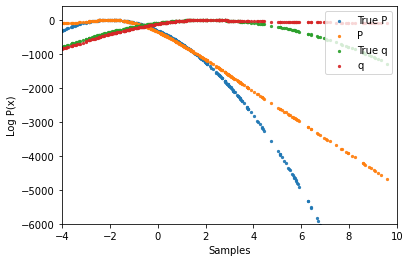

In [31]:
rat_p = log_r_p_from_m_direct_store[-1][:,0]- cauchy.logpdf(xs,loc=mu_3,scale=scale_m)
rat_q = log_r_p_from_m_direct_store[-1][:,1]- cauchy.logpdf(xs,loc=mu_3,scale=scale_m)

d = [np.squeeze(norm.logpdf(x,mu_2,scale_q)) for x in xs]
b = [np.squeeze(norm.logpdf(x,mu_1,scale_p)) for x in xs]

plt.scatter(xs,b,label='True P',alpha=0.9,s=5.)
plt.scatter(xs,rat_p,label='P',alpha=0.9,s=5.)
plt.scatter(xs,d,label='True q',alpha=0.9,s=5.)
plt.scatter(xs,rat_q,label='q',alpha=0.9,s=5.)

plt.xlabel("Samples")
plt.ylabel("Log P(x)")
plt.legend(loc='upper right')
plt.xlim(-4.,10)
plt.ylim(-6000,400)

In [ ]:

# Training
loss2 = []
pbar = (range(0,100000))
for i in pbar:
    # Train
    feed_dict = {}
    l2,_ = sess.run([dloss, c_optim],feed_dict=feed_dict)
    loss2.append(l2)

fig = plt.figure()
ax = plt.axes()
plt.plot(loss2, label='CoB')
ax.set_xlabel('Iterations' )
ax.set_ylabel('Loss')
plt.legend(loc='upper right')